In [1]:
import os, sys
import argparse
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from scipy.stats import mode

from tensorboardX import SummaryWriter
import imageio
import cv2
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

from xgboost import XGBClassifier


### Args ###:
features_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/feats_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.csv"
thumbnails_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/thumbnails_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.npy"
sprite_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/sprite_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.png"
labels_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/labels_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.tsv"
thumbnail_size = 64
pca_reduce = 2/3
###

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    spriteimage = np.ones((img_h * n_plots, img_w * n_plots, 3))

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                j * img_w:(j + 1) * img_w] = this_img

    return spriteimage

# Preprocess

In [2]:
### Preprocessing and visualization ###
run_time = time.time()
with open(features_file, 'r') as feats_file:
    X = np.loadtxt(feats_file, skiprows=1)  # need to skip header row (?)
run_time = time.time() - run_time
print("X's shape is ", X.shape)
print("Run in {}s".format(run_time))

X's shape is  (5490, 21172)
Run in 109.97560501098633s


In [3]:
np.where(np.isnan(X[0,:]))[0]

array([], dtype=int64)

# Embedding

In [4]:
# Check X:
good = np.all(np.isfinite(X))
print(good)
if not good:        
    X[np.isnan(X)] = 0.0

False


In [5]:
# Preprocessing
X = StandardScaler().fit_transform(X)

In [6]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
pca = PCA(n_components=int(X.shape[1]*pca_reduce), whiten=True)  # reduce number of features
#dec = FastICA(n_components=int(X.shape[1]*pca_reduce), whiten=True, max_iter=200)
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
pca = pca.fit(X)
X_pca = pca.transform(X)
run_time = time.time() - run_time
print("X_new's shape is ", X_pca.shape)
print("Run in {}s".format(run_time))

X_new's shape is  (5490, 5490)
Run in 146.9671459197998s


In [8]:
# Correlate PCA sources with size:
size = X[:,-1]  # after being scaled with StandardScaler
print(size[0:10])
x_corr_size = []
p_values = []
for x in X_pca.T:
    corr, p_value = pearsonr(x, size)
    x_corr_size.append(corr)
    p_values.append(p_value)

maxcorr_x = np.argmax([abs(c) for c in x_corr_size])
maxcorr = x_corr_size[maxcorr_x]
print("Max correlation = {} (component #{}), with p value = {}".format(
    maxcorr, maxcorr_x, p_values[maxcorr_x]))

X_pca[:,maxcorr_x] = 0
X_trimmed = pca.inverse_transform(X_pca)
#assert X_trimmed.shape[1] == X_pca.shape[1] - 1

[ 1.12145222  1.12145222  0.1324963   1.51004344  0.70724022  1.72811867
  0.30814545  0.04773252 -0.4646227   0.7433769 ]
Max correlation = -0.9484795664613397 (component #0), with p value = 0.0


[5.37645519e-01 1.04002100e-01 9.77203295e-02 ... 2.24875414e-36
 1.55560625e-36 2.35079880e-37]
524


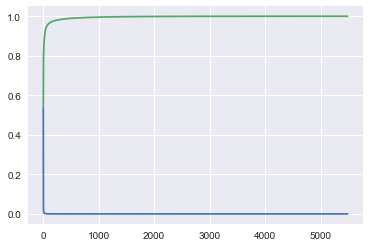

In [10]:
sns.set(style="darkgrid")
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
ninetynine = np.where(cum_var > 0.99)[0][0]
print(ninetynine)

In [11]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
dec = FastICA(n_components=ninetynine, whiten=True, max_iter=1000)  # assuming components are already whitened!
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
dec = dec.fit(X_trimmed)
X_ica = dec.transform(X_trimmed)
run_time = time.time() - run_time
print("X_ica's shape is ", X_ica.shape)
print("Run in {}s".format(run_time))

/Users/andreachatrian/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


X_ica's shape is  (5490, 524)
Run in 312.18376874923706s


In [12]:
# Open thumbnails file
with open(thumbnails_file, 'rb') as tnbs_file:
    thumbnails = np.load(tnbs_file)

In [13]:
# t-SNE with tensorboard
log_dir = Path(features_file).parent/"projector"
try:
    os.mkdir(log_dir)
except FileExistsError:
    pass
writer = SummaryWriter(log_dir=str(log_dir))

In [14]:
# Correlate ICA sources with size:
size = X[:,-1]
x_corr_size = []
p_values = []
for x in X_ica.T:
    corr, p_value = pearsonr(x, size)
    x_corr_size.append(corr)
    p_values.append(p_value)

maxcorr_x = np.argmax(x_corr_size)
maxcorr = x_corr_size[maxcorr_x]
print("Max correlation = {}, with p value = {}".format(maxcorr, p_values[maxcorr_x]))

Max correlation = 0.13133460849950038, with p value = 1.4950455681150344e-22


In [15]:
X_t = torch.from_numpy(X_ica)
thumbnails_t = torch.from_numpy(thumbnails).permute(0,3,1,2).type(torch.float32)  # turn to NCHW for tensorboardX embedding
print(X_t.shape)
print(thumbnails_t.shape)
writer.add_embedding(X_t, label_img=thumbnails_t)

torch.Size([5490, 524])
torch.Size([5490, 3, 64, 64])


In [16]:
# Check sprite:
from imageio import imread
sprite = imread(sprite_file)

uint8
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 

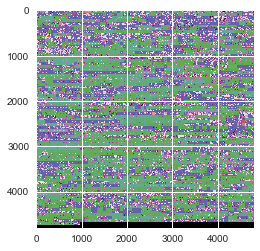

In [17]:
plt.imshow(sprite)
print(sprite.dtype)
print(np.unique(sprite))

In [18]:
"""
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector


tf_X = tf.Variable(X_new, trainable=False)
saver = tf.train.Saver([tf_X])

# based on https://www.easy-tensorflow.com/tf-tutorials/tensorboard/tb-embedding-visualization
# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/

th_size = (100,) * 2
with tf.Session() as sess:

    sess.run(tf_X.initializer)

    writer = tf.summary.FileWriter(str(log_dir /"projector"), sess.graph)

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = 'embeddingding:0'
    embedding.sprite.image_path = str(log_dir/"projector"/sprite_file)
    projector.visualize_embeddings(summary_writer=writer, config=config)
    
    dir(embedding.sprite)
import inspect
inspect.getmembers(embedding.sprite)

"""

'\nimport tensorflow as tf\nfrom tensorflow.contrib.tensorboard.plugins import projector\n\n\ntf_X = tf.Variable(X_new, trainable=False)\nsaver = tf.train.Saver([tf_X])\n\n# based on https://www.easy-tensorflow.com/tf-tutorials/tensorboard/tb-embedding-visualization\n# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/\n\nth_size = (100,) * 2\nwith tf.Session() as sess:\n\n    sess.run(tf_X.initializer)\n\n    writer = tf.summary.FileWriter(str(log_dir /"projector"), sess.graph)\n\n    config = projector.ProjectorConfig()\n    embedding = config.embeddings.add()\n    embedding.tensor_name = \'embeddingding:0\'\n    embedding.sprite.image_path = str(log_dir/"projector"/sprite_file)\n    projector.visualize_embeddings(summary_writer=writer, config=config)\n    \n    dir(embedding.sprite)\nimport inspect\ninspect.getmembers(embedding.sprite)\n\n'

# Clustering

# Prediction

In [23]:
labels = np.loadtxt(labels_file, delimiter='\t')

In [25]:
X_train = X_ica[0:-500, :]
y_train = labels
X_test = X_ica[500:, :]
y_train = labels[0:-500]
y_test = labels[500:]
xgbc = XGBClassifier(max_dept = 5, n_estimators = 150, subsample = 0.8)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_dept=5, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=150, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [26]:
y_hat = xgbc.predict(X_test)
acc = np.mean(y_hat == y_test)
print(acc)

0.9164328657314629


/Users/andreachatrian/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
